In [1]:
#import nmresearch as nmr
import scipy as sp
import numpy as np
from numpy import pi, sqrt
import matplotlib.pyplot as plt
import qutip as qt
from qutip import hinton, identity, to_super, sigmaz, tensor, tensor_contract, sigmax, projection, jmat, basis, propagator, coefficient

In [2]:
Sz = tensor(jmat(1/2,'z'), identity([2]))
Sx = tensor(jmat(1/2,'x'),identity([2]))
Sy = tensor(jmat(1/2,'y'),identity([2]))

Iz = tensor(identity(2), jmat(1/2,'z'))
Ix = tensor(identity(2), jmat(1/2,'x'))
Iy = tensor(identity(2), jmat(1/2,'y'))

In [86]:
sqrt2 = np.sqrt(2)
isqrt2 = 1/np.sqrt(2)

GHz=1e3
MHz=1
kHz=1e-3

ms=1e3
us=1
ns=1e-3

T = 1e4
G = 1

B = 360

gamma_e = -28024 * MHz / T
gamma_p = 42.577 * MHz / T
gamma_N = -4.316 * MHz / T

omegaNV =  2.87 * GHz + gamma_e * B
omegaX = gamma_e * B
omegaN15 = gamma_N * B
omegaP = gamma_p * B

Anv = 3.06*MHz
D = 60 * kHz
Omega = 1 * MHz

T1e = 1*ms
T2e = 50*us
T1n = 10*ms
T2n = 500*us

T1e_rho = 100*us # this is emergent, no need to add directly

t_swap_nvx = 7.95*us

deg = np.pi/180

In [87]:
e0 = basis(2,0)
e1 = basis(2,1)
n0 = basis(2,0)
n1 = basis(2,1)

ket00 = tensor(e0,n0)
ket01 = tensor(e0,n1)
ket10 = tensor(e1,n0)
ket11 = tensor(e1,n1)

rho00 = tensor(projection(2,0,0), projection(2,0,0))
rho01 = tensor(projection(2,0,0), projection(2,1,1))
rho10 = tensor(projection(2,1,1), projection(2,0,0))
rho11 = tensor(projection(2,1,1), projection(2,1,1))

In [88]:
e_c_ops = [1/(2*T1e) * Sx, 1/(2*T1e) * Sy, 1/(2*T2e) * Sz]

n_c_ops = [1/(2*T1n) * Ix, 1/(2*T1n) * Iy, 1/(2*T2n) * Iz]

lindblad_ops = e_c_ops + n_c_ops 

In [89]:
def noise(t):
    # computes noise propegator for a time t while no 
    # other evolution is occuring
    return propagator(identity([2,2]), t, c_ops=lindblad_ops)

def partial_pol_state(pol):
    # returns a state partially polarize along Z
    # polarization must be a number between -1 and 1
    assert abs(pol) <= 1
    return (1+pol)/2*projection(2,0,0) + (1-pol)/2*projection(2,1,1)

def nv_reset(pol):
    return tensor(projection(2,0,0), partial_pol_state(pol), prho)

In [90]:
H = 2*pi*(omegaNV * Sz + omegaN15 * Iz + Anv * (Sz * Iz))

H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 5851.24969359     0.             0.             0.        ]
 [    0.          5842.61267627     0.             0.        ]
 [    0.             0.         -5852.22594979     0.        ]
 [    0.             0.             0.         -5841.63642007]]

In [91]:
energies = H.eigenenergies()

In [92]:
energies

array([-5852.22594979, -5841.63642007,  5842.61267627,  5851.24969359])

In [93]:
omega_bar = abs(omegaNV + omegaN15)
delta_omega = abs(omegaNV - omegaN15)

In [94]:
2*pi*(-omega_bar/2 + Anv/4)

-5841.636420071357

In [95]:
2*pi*(-delta_omega/2 - Anv/4)

-5852.225949791629

In [96]:
2*pi*(delta_omega/2 - Anv/4)

5842.612676271645

In [97]:
2*pi*(omega_bar/2 + Anv/4)

5851.249693591341

In [98]:
omega_cnot21_MEAS = (energies[1]-energies[2])/(2*pi)
omega_cnot12_MEAS = (energies[1]-energies[0])/(2*pi)

In [99]:
d1 = (energies[1]-energies[2])/(2*pi)

In [100]:
d2 = (energies[0]-energies[3])/(2*pi)

In [101]:
omega_double = (d2+d1)/2

In [102]:
HrE = 2*pi*((omegaNV + d1) * Sz + omegaN15 * Iz + Anv * (Sz * Iz) + 1.4*MHz*Sx)

HrE

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[  9.12514542   0.           4.39822972   0.        ]
 [  0.           0.4881281    0.           4.39822972]
 [  4.39822972   0.         -10.10140162   0.        ]
 [  0.           4.39822972   0.           0.4881281 ]]

In [103]:
times = np.arange(0,1,.005)


resE = qt.mesolve(HrE,rho01,times,c_ops=lindblad_ops)
signal = [qt.expect(rho11, state) for state in resE.states]
#signal = [ abs(ket11.trans() * (-1j * t * HrE).expm() * ket01)**2 for t in times]
#signal_other = [ abs(ket10.trans() * (-1j * t * HrE).expm() * ket00)**2 for t in times]
t_cnot_e = times[np.argmax(signal)]

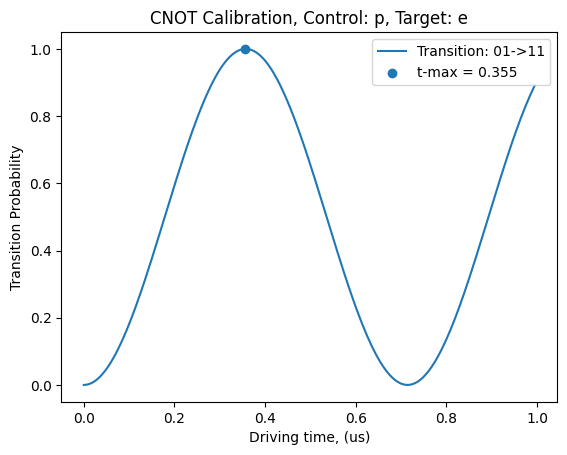

In [104]:
plt.plot(times,signal,label="Transition: 01->11")
#plt.plot(times,signal_other,label="Leakage")
plt.scatter(t_cnot_e, np.max(signal),label=f"t-max = {t_cnot_e}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: p, Target: e")
plt.legend()
plt.show()

In [105]:
HrEo = 2*pi*((omegaNV + d2) * Sz + omegaN15 * Iz + Anv * (Sz * Iz) + 1.4*MHz*Sx)

HrEo

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-0.4881281   0.          4.39822972  0.        ]
 [ 0.         -9.12514542  0.          4.39822972]
 [ 4.39822972  0.         -0.4881281   0.        ]
 [ 0.          4.39822972  0.         10.10140162]]

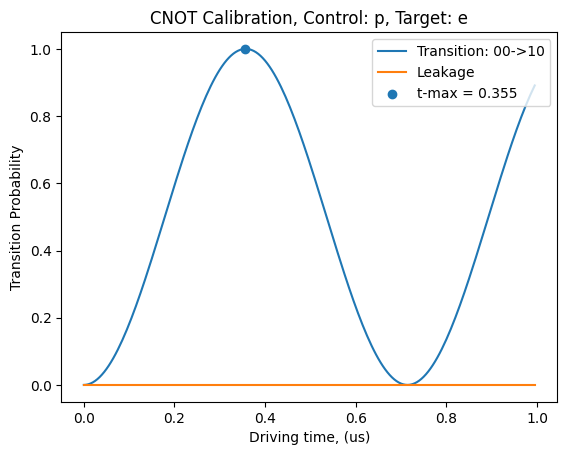

In [106]:
times = np.arange(0,1,.005)


resE = qt.mesolve(HrEo,rho00,times,c_ops=lindblad_ops)
signal = [qt.expect(rho10, state) for state in resE.states]
leakage = [qt.expect(rho01, state)+qt.expect(rho11, state) for state in resE.states]
#signal = [ abs(ket11.trans() * (-1j * t * HrE).expm() * ket01)**2 for t in times]
#signal_other = [ abs(ket10.trans() * (-1j * t * HrE).expm() * ket00)**2 for t in times]
t_cnot_e_o = times[np.argmax(signal)]

plt.plot(times,signal,label="Transition: 00->10")
plt.plot(times,leakage,label="Leakage")
plt.scatter(t_cnot_e_o, np.max(signal),label=f"t-max = {t_cnot_e_o}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: p, Target: e")
plt.legend()
plt.show()

In [107]:
HrEb = 2*pi*((omegaNV + omega_double) * Sz + omegaN15 * Iz + Anv * (Sz * Iz) + 1.4*MHz*Sx)

HrEb

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.31850866  0.          4.39822972  0.        ]
 [ 0.         -4.31850866  0.          4.39822972]
 [ 4.39822972  0.         -5.29476486  0.        ]
 [ 0.          4.39822972  0.          5.29476486]]

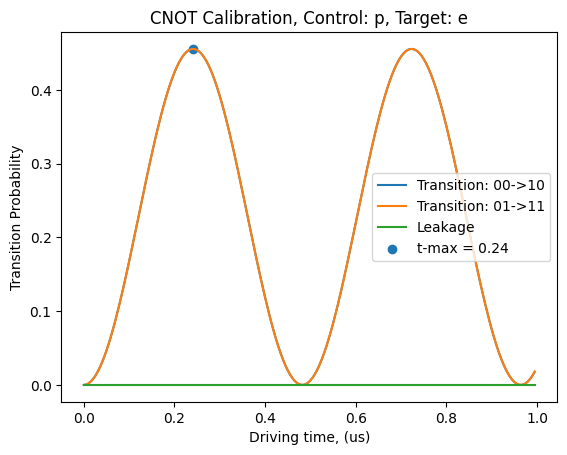

In [108]:
times = np.arange(0,1,.005)


resE = qt.mesolve(HrEb,rho00,times,c_ops=lindblad_ops)
resEo = qt.mesolve(HrEb,rho01,times,c_ops=lindblad_ops)
signal = [qt.expect(rho10, state) for state in resE.states]
signal_other = [qt.expect(rho11, state) for state in resEo.states]
leakage = [qt.expect(rho01, state)+qt.expect(rho11, state) for state in resE.states]
#signal = [ abs(ket11.trans() * (-1j * t * HrE).expm() * ket01)**2 for t in times]
#signal_other = [ abs(ket10.trans() * (-1j * t * HrE).expm() * ket00)**2 for t in times]
t_pi = times[np.argmax(signal)]

plt.plot(times,signal,label="Transition: 00->10")
plt.plot(times,signal_other,label="Transition: 01->11")
plt.plot(times,leakage,label="Leakage")
plt.scatter(t_pi, np.max(signal),label=f"t-max = {t_pi}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: p, Target: e")
plt.legend()
plt.show()

In [109]:
cnot_e = propagator(HrE, t_cnot_e, c_ops=lindblad_ops)

In [110]:
qt.unitarity(cnot_e)

0.9999792299079888

In [111]:
np.max(signal)

0.4556946716529866

In [112]:
# this is a time dependent hamiltonian with slow terms that might matter

HrN =  2*pi*((omegaN15+omega_cnot12_MEAS) * Iz + Anv * (Sz * Iz) + 20 * kHz*Ix)

HrN

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 9.61327352e+00  6.28318531e-02  0.00000000e+00  0.00000000e+00]
 [ 6.28318531e-02 -9.61327352e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -3.67621340e-13  6.28318531e-02]
 [ 0.00000000e+00  0.00000000e+00  6.28318531e-02  3.67621340e-13]]

In [113]:
times = np.arange(0,1/(20*kHz),.1)
res = qt.mesolve(HrN, rho10, times, c_ops=lindblad_ops)
res_leak = qt.mesolve(HrN, rho00, times, c_ops=lindblad_ops)

In [114]:
nuc_signal = [qt.expect(rho11, state) for state in res.states]
nuc_signal_other = [qt.expect(rho01, state) for state in res_leak.states]

In [115]:
#nuc_signal = [ abs(ket11.trans() * (-1j * t * HrN).expm() * ket10)**2 for t in times]
#nuc_signal_other = [ abs(ket01.trans() * (-1j * t * HrN).expm() * ket00)**2 for t in times]
t_cnot_nuc = times[np.argmax(nuc_signal)]

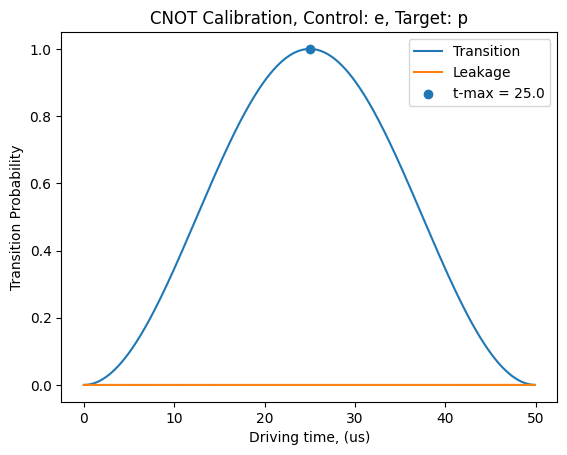

In [116]:
plt.plot(times,nuc_signal,label="Transition")
plt.plot(times,nuc_signal_other,label="Leakage")
plt.scatter(t_cnot_nuc, np.max(nuc_signal),label=f"t-max = {t_cnot_nuc}")
plt.xlabel("Driving time, (us)")
plt.ylabel("Transition Probability")
plt.title("CNOT Calibration, Control: e, Target: p")
plt.legend()
plt.show()

In [117]:
np.max(nuc_signal)

0.9999748185941484

In [118]:
t_cnot_nuc

25.0

In [119]:
cnot_n = propagator(HrN, t_cnot_nuc, c_ops=lindblad_ops,options={'nsteps':1e7})

In [120]:
qt.unitarity(cnot_n)

0.9929364371242043

In [121]:
sqrt(qt.process_fidelity(cnot_n, qt.gates.cnot()))

0.5025863964619248

In [122]:
qt.gates.cnot()

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [123]:
swap = cnot_e*cnot_n*cnot_e

In [124]:
qt.unitarity(swap)

0.9928951863230964

In [125]:
rho10

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [126]:
rho01

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [127]:
qt.vector_to_operator(swap * qt.operator_to_vector(rho01))

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.69948275e-02-1.45658105e-20j -1.99412006e-05-7.10901018e-06j
  -1.24567958e-01-1.95497518e-01j  7.52334833e-04-2.11656612e-03j]
 [-1.99412006e-05+7.10901018e-06j  3.15527070e-06+1.31000017e-20j
   6.78860448e-05+5.29122981e-05j -1.20927942e-08+7.59068214e-07j]
 [-1.24567958e-01+1.95497518e-01j  6.78860448e-05-5.29122981e-05j
   9.42907142e-01+1.15005099e-20j  5.61623920e-03+7.20696569e-03j]
 [ 7.52334833e-04+2.11656612e-03j -1.20927942e-08-7.59068214e-07j
   5.61623920e-03-7.20696569e-03j  9.48751397e-05-1.30963910e-20j]]

In [128]:
sqrt(qt.process_fidelity(swap, qt.to_super(qt.gates.swap())))

0.20575888567316844

In [129]:
qt.unitarity(swap)

0.9928951863230964

In [130]:
np.sqrt(qt.average_gate_fidelity(swap,qt.gates.swap()))

0.483600428305071